## Project description.

In this project I'm taking a role of an intern in the analytical department at Yandex.Afisha. My first task would be to help optimize marketing expenses.

##### What do we have:
 - Server logs with data on Yandex.Afisha visits from June 2017 through May 2018
 - Dump file with all orders for the period
 - Marketing expenses statistics

##### What are we going to study:
 - How people use the product
 - When they start to buy
 - How much money each customer brings
 - When they pay off

#### The process would include the following steps:

**[Step 1. Downloading the data and preparing it for analysis](#Step-1.-Downloading-the-data-and-preparing-it-for-analysis)**  <br>

**[Step 2. Making reports and calculating metrics](#Step-2.-Making-reports-and-calculating-metrics)**
 1. **[Product](#Product)**
  - [How many people use it every day, week, and month?](#How-many-people-use-it-every-day,-week,-and-month?)
  - [How many sessions are there per day?](#How-many-sessions-are-there-per-day?)
  - [What is the length of each session?](#What-is-the-length-of-each-session?)
  - [How often do users come back?](#How-often-do-users-come-back?) <br>
<br>
 2. **[Sales](#Sales)** 
  - [When do people start buying?](#When-do-people-start-buying?)
  - [How many orders do customers make during a given period of time?](#How-many-orders-do-customers-make-during-a-given-period-of-time?)
  - [What is the average purchase size?](#What-is-the-average-purchase-size?)
  - [How much money do they bring?](#How-much-money-do-they-bring?) <br>
<br>
 3. **[Marketing](#Marketing)**
  - [How much money was spent?](#How-much-money-was-spent?)
  - [How much did customer acquisition from each of the sources cost?](#How-much-did-customer-acquisition-from-each-of-the-sources-cost?)
  - [How worthwhile where the investments?](#How-worthwhile-where-the-investments?)
  
**[Step 3. Overall conclusion](#Step-3.-Overall-conclusion)**

## Step 1. Downloading the data and preparing it for analysis

Let's import and open our datasets:

#### Description of the data:

The `visits` table (server logs with data on website visits):
 - *Uid* — user's unique identifier
 - *Device* — user's device
 - *Start Ts* — session start date and time
 - *End Ts* — session end date and time
 - *Source Id* — identifier of the ad source the user came from

The `orders` table (data on orders):
 - *Uid* — unique identifier of the user making an order
 - *Buy Ts* — order date and time
 - *Revenue* — Yandex.Afisha's revenue from the order
 
The `costs` table (data on marketing expenses):
 - *source_id* — ad source identifier
 - *dt* — date
 - *costs* — expenses on this ad source on this day 

In [303]:
import pandas as pd

orders_log = pd.read_csv("orders_log_us.csv")
visits_log = pd.read_csv("visits_log_us.csv")
costs = pd.read_csv("costs_us.csv")

for item in [orders_log, visits_log, costs]:
    print([x for x in globals() if globals()[x] is item][0])
    item.info()
    display(item.head(3))

orders_log
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844


visits_log
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527


costs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53


We don't have any missing values here. <br>
There are several columns that might need to be converted to *datetime* format or *category* data type instead of *object*, that will help us to optimize the data and so it won't use that much memory.

In [304]:
orders_log['Buy Ts'] =  pd.to_datetime(orders_log['Buy Ts'], format="%Y-%m-%d %H:%M:%S")
visits_log['End Ts'] =  pd.to_datetime(visits_log['End Ts'], format="%Y-%m-%d %H:%M:%S")
visits_log['Start Ts'] =  pd.to_datetime(visits_log['Start Ts'], format="%Y-%m-%d %H:%M:%S")
costs['dt'] =  pd.to_datetime(costs['dt'], format="%Y-%m-%d")

visits_log['Device'] = visits_log['Device'].astype('category') 

Aslo let's lowercase column names and replace spaces with underscores, so it would be easier to work with:

In [305]:
visits_log.columns = visits_log.columns.str.lower()
orders_log.columns = orders_log.columns.str.lower()
visits_log.columns = visits_log.columns.str.replace(" ", "_")
orders_log.columns = orders_log.columns.str.replace(" ", "_")

## Step 2. Making reports and calculating metrics

### Product

#### How many people use it every day, week, and month?

At this step we are going to calculate *DAU*, *WAU* and *MAU*:

 - *DAU* — the number of daily active (unique) users
 - *WAU* — the number of weekly active users
 - *MAU* — the number of monthly active users

In [306]:
visits_log['year']  = visits_log['start_ts'].dt.year
visits_log['month'] = visits_log['start_ts'].dt.month
visits_log['week']  = visits_log['start_ts'].dt.week
visits_log['date'] = visits_log['start_ts'].dt.date

Now let's calculate metrics. We'll group the data by session date/week/month and find the means:

In [307]:
dau_mean = visits_log.groupby('date').agg({'uid': 'nunique'}).mean()
wau_mean = visits_log.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()
mau_mean = visits_log.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()

print("Daily active unique users:", int(dau_mean))
print("Weekly active unique users:", int(wau_mean))
print("Monthly active unique users:", int(mau_mean))

Daily active unique users: 907
Weekly active unique users: 5716
Monthly active unique users: 23228


Let's plot a line graph for daily activity:

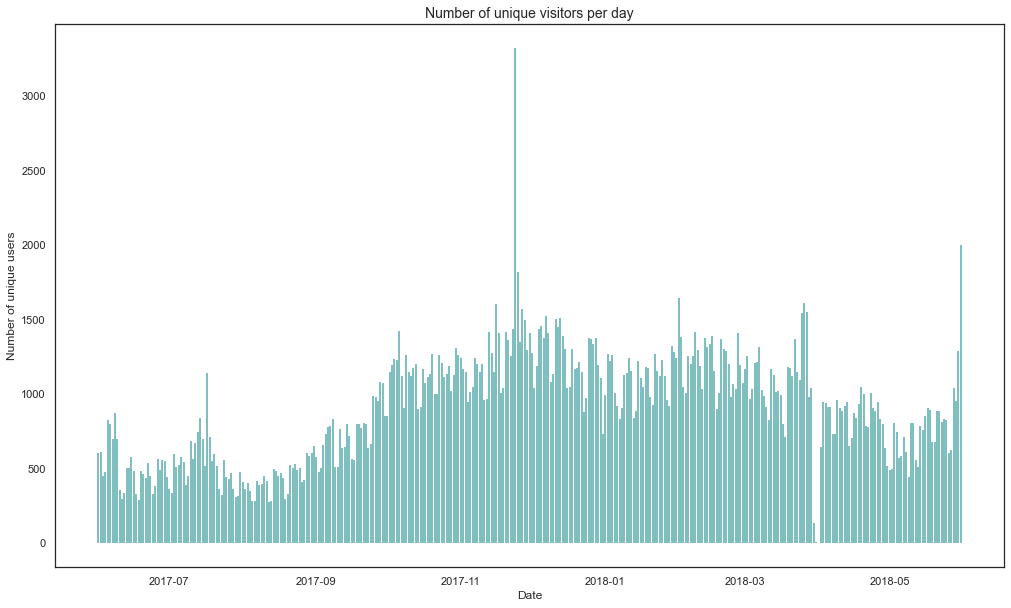

In [308]:
import matplotlib as mpl
from matplotlib import pyplot as plt

dau = visits_log.groupby('date').agg({'uid': 'nunique'})

fig,ax = plt.subplots(figsize = (17,10))
ax.vlines(x = dau.index, 
          ymin = 0, 
          ymax = dau.uid, 
          color = 'teal',
          alpha = 0.5, 
          linewidth = 2)

ax.set_title('Number of unique visitors per day', fontdict ={'size':14})
ax.set_ylabel('Number of unique users', fontdict ={'size':12})
ax.set_xlabel('Date', fontdict ={'size':12})
plt.show()    

There is some increment in activity since October and a large peak around December, probably people are looking for some New Year activities. There is also some activity drop during April 2018.

Graph for monthly activity:

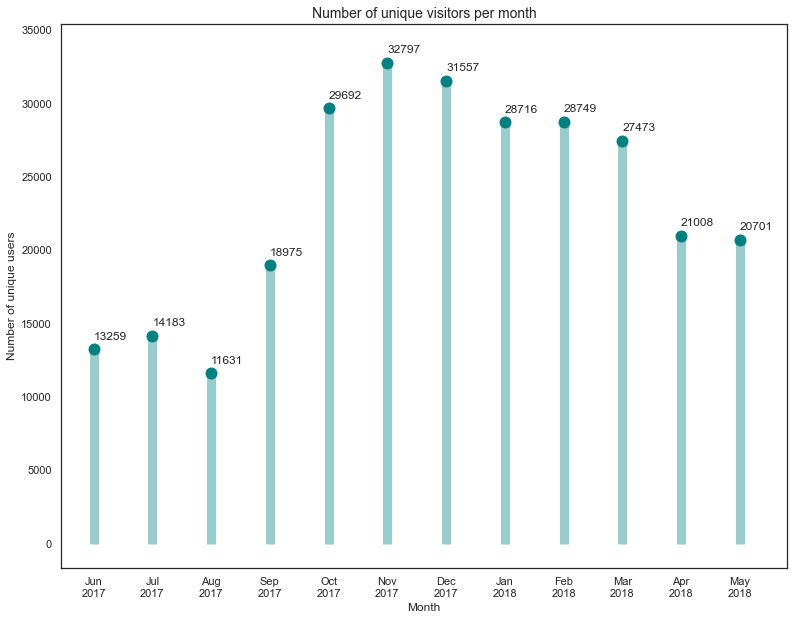

In [309]:
import numpy as np
import calendar

mau = visits_log.groupby(['year', 'month']).agg({'uid': 'nunique'}).reset_index()
mau['month'] = mau['month'].apply(lambda x: calendar.month_abbr[x])

def monthly_lollipop_chart(df, y_values, decimal, title, ylabel):
    fig,ax = plt.subplots(figsize = (13,10))
    
    ax.vlines(x=df.index, 
              ymin=0, 
              ymax=df[y_values], 
              color='teal',
              alpha=0.4, 
              linewidth = 9)
       
    ax.scatter(x=df.index, 
               y=df[y_values], 
               s=120, 
               color='teal')
    
    shift = df[y_values].max()*0.02
    
    for index, row in df.iterrows():
        ax.text(x=index,
                y=row[y_values] + shift,
                s=round(row[y_values], decimal))   
    
    ax.set_title(title, fontdict ={'size':14})
    ax.set_ylabel(ylabel, fontdict ={'size':12})
    ax.set_xlabel('Month', fontdict ={'size':12})
    ax.set_ylim(ymax=df[y_values].max()*1.08)
    ax.set_xlim(xmax=11.8)
    ax.set_xticks(np.arange(df.shape[0]))
    ax.set_xticklabels(mau.month.astype(str) + "\n" + mau.year.astype(str))
    plt.show()    

monthly_lollipop_chart(df=mau,
                       y_values='uid',
                       decimal=0,
                       title='Number of unique visitors per month',
                       ylabel='Number of unique users')      

We see that November is the top month by user activity while in August users are the least active. In general, service gets less activity during the summer and most demanded during the winter.

#### How many sessions are there per day? 

Let's calculate how many sessions are there per day:

In [310]:
sessions_per_day_mean = visits_log.groupby('date').agg({'uid': 'count'}).mean()
print("Average number of sessions per day:", int(sessions_per_day_mean))

Average number of sessions per day: 987


There are around *987* sessions per day on average.

One user might have more than one session. As we learned above, average DAU is *907*, so let's find average number of sessions per user per one day:

In [311]:
sessions_per_user = sessions_per_day_mean / dau_mean
print("Average sessions per user per one day:", round(float(sessions_per_user), 2))

Average sessions per user per one day: 1.09


So, there's slightly more than one session per day per one user: *1.09* <br>
Majority of people are using the service only once a day. 

Let's check if that applies to every day or some days there could be a bigger number of sessions per user. Let's take a look at daily dynamics:

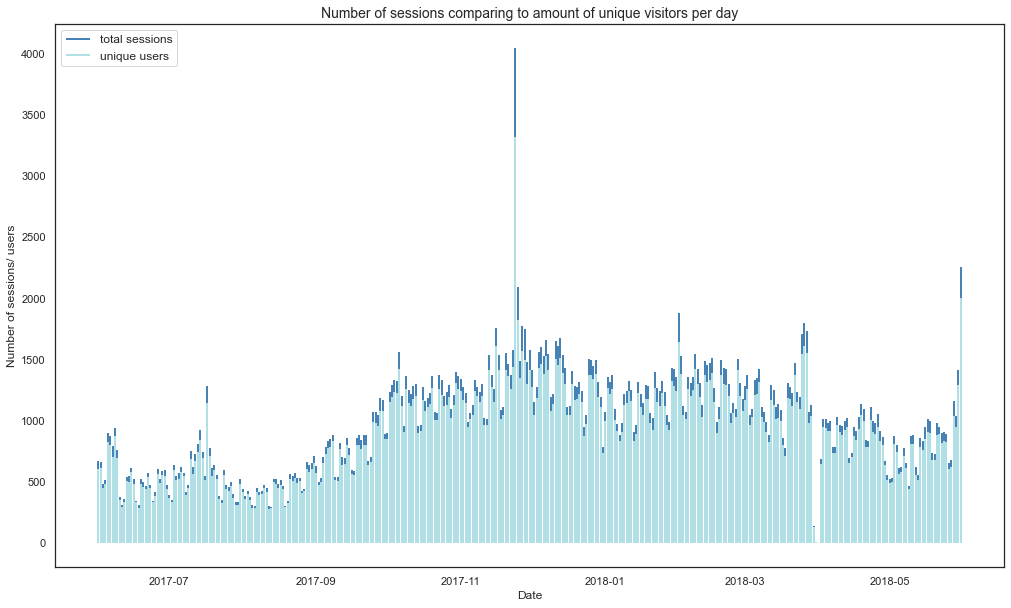

In [312]:
sessions_per_day = visits_log.groupby('date').agg({'uid': 'count'})

fig,ax = plt.subplots(figsize = (17,10))
ax.vlines(x = sessions_per_day.index, 
          ymin = 0, 
          ymax = sessions_per_day.uid, 
          color = 'steelblue',
          label="total sessions",
          linewidth = 2)

ax.vlines(x = dau.index, 
          ymin = 0, 
          ymax = dau.uid, 
          color = 'powderblue',
          label="unique users",
          linewidth = 2)

ax.set_title('Number of sessions comparing to amount of unique visitors per day', fontdict ={'size':14})
ax.set_ylabel('Number of sessions/ users', fontdict ={'size':12})
ax.set_xlabel('Date', fontdict ={'size':12})
plt.legend(loc="upper left", fontsize=12)
plt.show() 

From the chart we see that the total number of sessions vary from one day to another, but the share between unique and multiple-time visitors stays around the same. There are a lot of repeated visits occurring at the peak activity day in December, but proportion of them to unique visits is about the same as usual. 

Let's split the distribution of sessions by device to see which platform dominates:

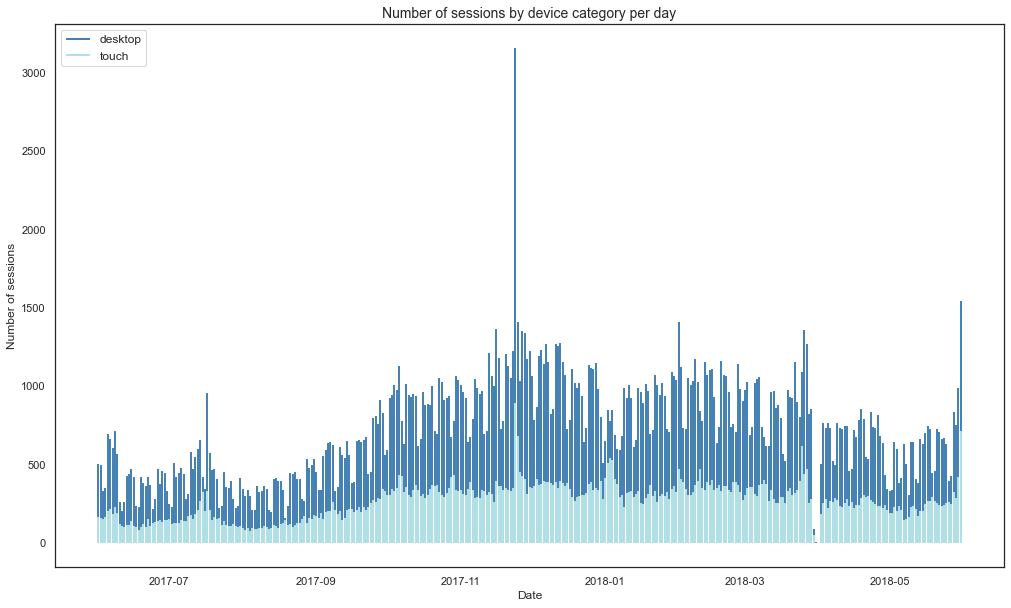

In [313]:
sessions_devices = visits_log.groupby(['date', 'device']).agg({'uid': 'count'}).reset_index()
sessions_desktop = sessions_devices[sessions_devices.device == 'desktop']
sessions_touch = sessions_devices[sessions_devices.device == 'touch']

fig,ax = plt.subplots(figsize = (17,10))
ax.vlines(x = sessions_desktop.date, 
          ymin = 0, 
          ymax = sessions_desktop.uid, 
          color = 'steelblue',
          label="desktop",
          linewidth = 2)

ax.vlines(x = sessions_touch.date, 
          ymin = 0, 
          ymax = sessions_touch.uid, 
          color = 'powderblue',
          label="touch",
          linewidth = 2)

ax.set_title('Number of sessions by device category per day', fontdict ={'size':14})
ax.set_ylabel('Number of sessions', fontdict ={'size':12})
ax.set_xlabel('Date', fontdict ={'size':12})
plt.legend(loc="upper left", fontsize=12)
plt.show() 

People use the service mostly from *desktop* devices. What is interesting, we see on the graph that the number of sessions from *touch* devices is changing over time, but changing quite smoothly, while the number of sessions from *desktop* devices has a sawtooth pattern. That can be due to the day of the week factor. People spend more time on desktop devices during the week and use them less during the weekend.

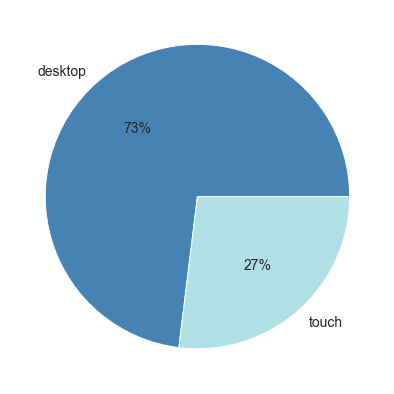

In [314]:
devices_share = sessions_devices.groupby('device').mean().astype(int)

fig,ax = plt.subplots(figsize = (7,7))
plt.pie(devices_share.uid.tolist(), 
        labels=devices_share.index.tolist(),
        autopct='%1.f%%',
        colors=['steelblue','powderblue'],
        textprops={'fontsize': 14})
plt.show()

On average, *desktop* devices are making 73% of all sessions and *touch* devices are making 27%.

#### What is the length of each session? 

Let's find out what is average session duration:

In [315]:
from time import strftime
from time import gmtime

visits_log['session_length'] = visits_log['end_ts'] - visits_log['start_ts']
session_length_mean = visits_log['session_length'].mean().total_seconds()
print("Average session lenght:", strftime("%M:%S", gmtime(session_length_mean)))

Average session lenght: 10:43


One session usually lasts *10 minutes 43 seconds*. <br>
Let's find out if this value varies for different devices types.

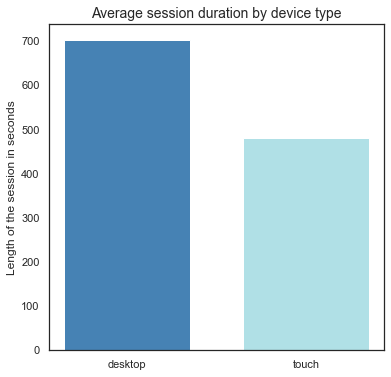

Average desktop session lenght: 11:43
Average touch session lenght: 07:59


In [316]:
session_length_desktop = visits_log[visits_log.device == 'desktop']['session_length'].mean().total_seconds()
session_length_touch = visits_log[visits_log.device == 'touch']['session_length'].mean().total_seconds()

fig,ax = plt.subplots(figsize = (6,6))
ax.bar(['desktop', 'touch'], 
       [session_length_desktop, session_length_touch],
        color = ['steelblue','powderblue'],
        width = 0.7)

ax.set_title('Average session duration by device type', fontdict ={'size':14})
ax.set_ylabel('Length of the session in seconds', fontdict ={'size':12})
plt.show() 

print("Average desktop session lenght:", strftime("%M:%S", gmtime(session_length_desktop)))
print("Average touch session lenght:", strftime("%M:%S", gmtime(session_length_touch)))

Desktop sessions are longer, on average, than mobile device sessions. They last *11 minutes 43 seconds*, while on touch devices - *7 minutes 59 seconds*.

Let's check how session length changes during the year. We are going to compare average session length per day in seconds to the average value per year that we calculated above: *10 minutes 43 seconds*.

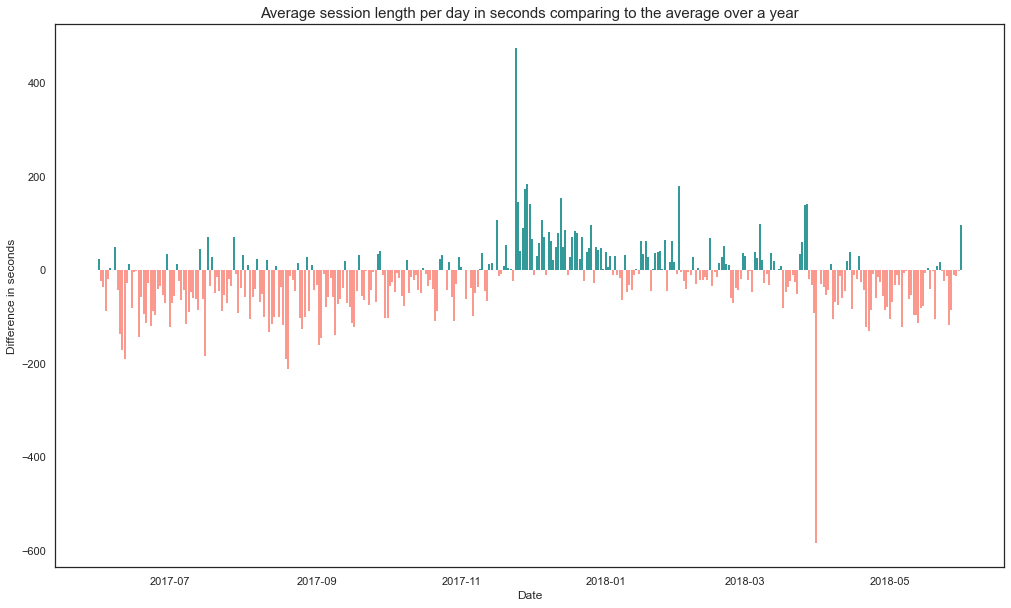

In [317]:
visits_log['session_length_sec'] = visits_log['session_length'].dt.total_seconds()
session_length = visits_log.groupby('date').agg({'session_length_sec': 'mean'})
session_length['session_length_z'] = session_length['session_length_sec'] - session_length_mean                        
session_length['colors'] = ['salmon' if x<0 else 'teal' for x in session_length['session_length_z']]

fig,ax = plt.subplots(figsize = (17,10))
ax.vlines(x = session_length.index, 
          ymin = 0, 
          ymax = session_length.session_length_z, 
          color=session_length.colors,
          alpha = 0.8,
          linewidth = 2)

ax.set_title('Average session length per day in seconds comparing to the average over a year', fontdict ={'size':15})
ax.set_ylabel('Difference in seconds', fontdict ={'size':12})
ax.set_xlabel('Date', fontdict={'size':12})
plt.show() 

We see the same pattern as we saw above with user activity. During the summer session length is usually lower than average and during the winter it rises. Longest sessions were taking place in December and in April there was some drop in session length.

#### How often do users come back?

Here we are going to calculate *retention rate*. <br>
We're going to split users to cohorts by registration month and then see which percent of the initial user amount remained active over next months: 

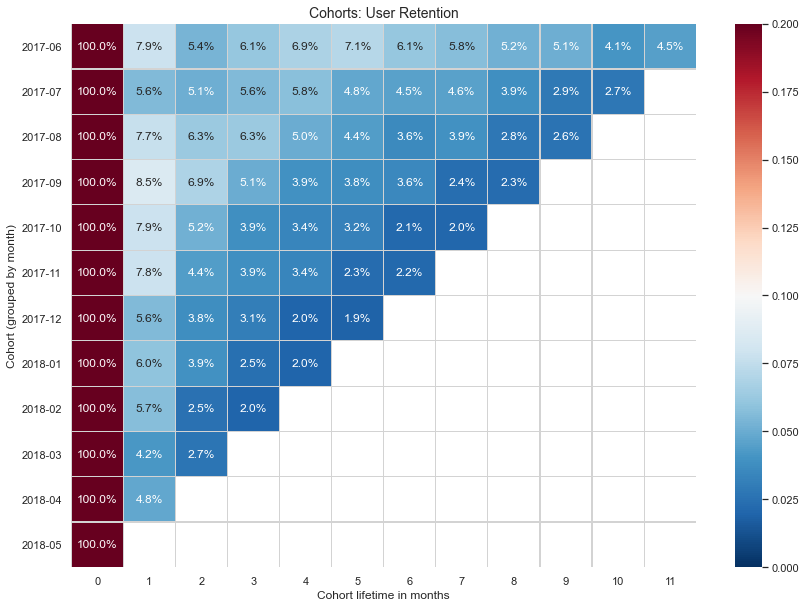

In [318]:
import seaborn as sns

first_activity_date = visits_log.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits_log = visits_log.join(first_activity_date,on='uid')
visits_log['first_activity_month'] = visits_log['first_activity_date'].astype('datetime64[M]')
visits_log['month_dt'] = visits_log['start_ts'].astype('datetime64[M]')

visits_grouped_by_cohorts = (visits_log
                             .groupby(['first_activity_month','month_dt'])
                             .agg({'uid':'nunique'})).reset_index()

visits_grouped_by_cohorts['cohort_lifetime'] = ((visits_grouped_by_cohorts['month_dt'] - 
                                                visits_grouped_by_cohorts['first_activity_month'])
                                                /np.timedelta64(1,'M')).round().astype('int64')

initial_users_count = visits_grouped_by_cohorts[visits_grouped_by_cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
visits_grouped_by_cohorts = visits_grouped_by_cohorts.merge(initial_users_count,on='first_activity_month')
visits_grouped_by_cohorts['retention'] = visits_grouped_by_cohorts['uid']/visits_grouped_by_cohorts['cohort_users']

visits_grouped_by_cohorts['first_activity_month'] = (visits_grouped_by_cohorts['first_activity_month']
                                                      .dt.strftime('%Y-%m'))

retention_pivot = visits_grouped_by_cohorts.pivot_table(index='first_activity_month',
                                                        columns='cohort_lifetime',
                                                        values='retention',
                                                        aggfunc='sum')

sns.set(style='white')
fig,ax = plt.subplots(figsize = (14,10))
sns.heatmap(retention_pivot, 
            annot=True,
            cmap='RdBu_r', 
            fmt='.1%', 
            linewidths=0.1, 
            linecolor='lightgrey',
            vmin = 0,
            vmax = 0.2,
           );
ax.set_title('Cohorts: User Retention', fontdict ={'size':14})
ax.set_xlabel('Cohort lifetime in months', fontdict ={'size':12})
ax.set_ylabel('Cohort (grouped by month)', fontdict ={'size':12})
ax.set_yticklabels(retention_pivot.index, rotation=0)
plt.show()

We see that most of the users are staying active only during the first month and only less than 9% of them would remain active during next months. Also there is a tendency for retention to decrease over time: June 2017 cohort stayed relatively active almost for the whole year having more than 5% activity of initial amount of users, while March and April 2018 cohorts dropped below 5% in the 2nd month of their lifetime already.

### Sales

#### When do people start buying?

Here we want to calculate the time that elapses between registration and the first purchase — when the user becomes a customer:

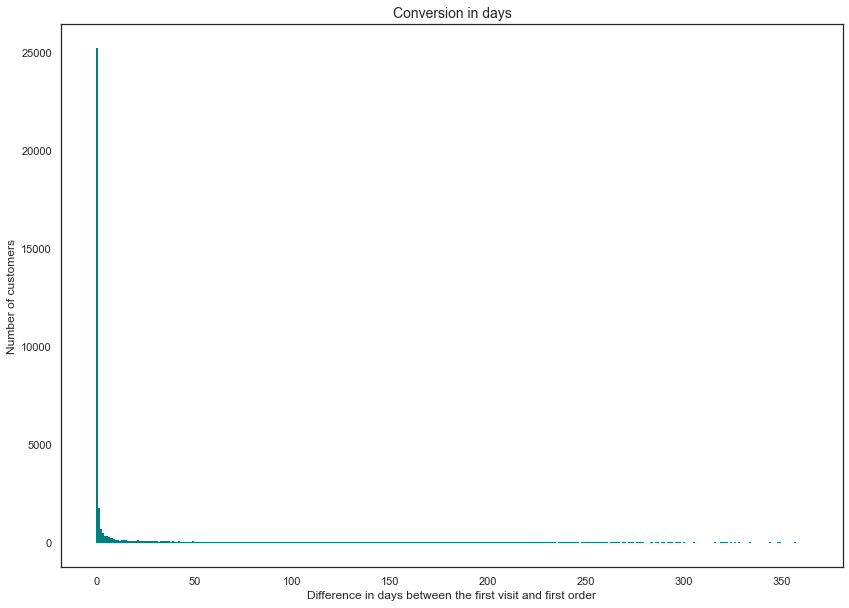

In [319]:
first_order_date = orders_log.groupby(['uid'])['buy_ts'].min()
first_order_date.name = 'first_order_date'
conversion = pd.concat([first_activity_date, first_order_date], axis=1)

conversion['difference_days'] = ((conversion['first_order_date']
                                  - conversion['first_activity_date'])
                                 /np.timedelta64(1,'D')).round().astype('Int64')

conversion_days = conversion.groupby('difference_days').agg({'difference_days':'count'})

fig,ax = plt.subplots(figsize = (14,10))
plt.vlines(x=conversion_days.index, 
           ymin=0, 
           ymax=conversion_days.difference_days, 
           color='teal',  
           linewidth=2)

ax.set_title('Conversion in days', fontdict ={'size':14})
ax.set_xlabel('Difference in days between the first visit and first order', fontdict ={'size':12})
ax.set_ylabel('Number of customers', fontdict ={'size':12})
plt.show()

Majority of customers are making their first order within the same day as they register on Yandex.Afisha. <br>
Let's calculate the percent of 0-day conversion out of all orders and the rest of them we can split into 3 groups: those who made the first purchase within the rest of the week after registration (not including the day of registration), within the rest of the month and rest of the year. This way groups wouldn't be too small and it would be easier to visualize our results:

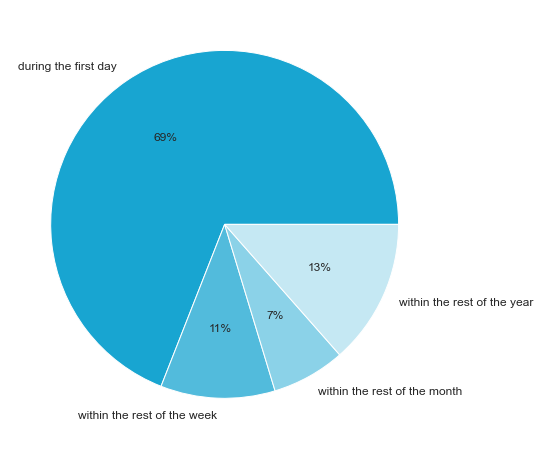

In [320]:
day = conversion_days[conversion_days.index == 0]['difference_days'].sum()
week = conversion_days[(conversion_days.index > 0) & (conversion_days.index <= 6)]['difference_days'].sum()
month = conversion_days[(conversion_days.index > 6) & (conversion_days.index <= 30)]['difference_days'].sum()
year = conversion_days[conversion_days.index > 30]['difference_days'].sum()

fig,ax = plt.subplots(figsize = (8,8))
plt.pie([day, week, month, year], 
        labels=["during the first day", "within the rest of the week", "within the rest of the month", "within the rest of the year"],
        autopct='%1.f%%',
        colors=['#18A5D1', '#52BBDC', '#8BD2E8', '#C5E8F3'],
        textprops={'fontsize': 12})
plt.show()

On average, *69%* of the customers make their first order the same day as they register. *11%* would make a purchase within a week after registration, *7%* within a month and the rest, *13%*, within a year. 

Let's compare the conversions of customers coming from different source, so we can determine which source is the most effective one in terms of marketing:

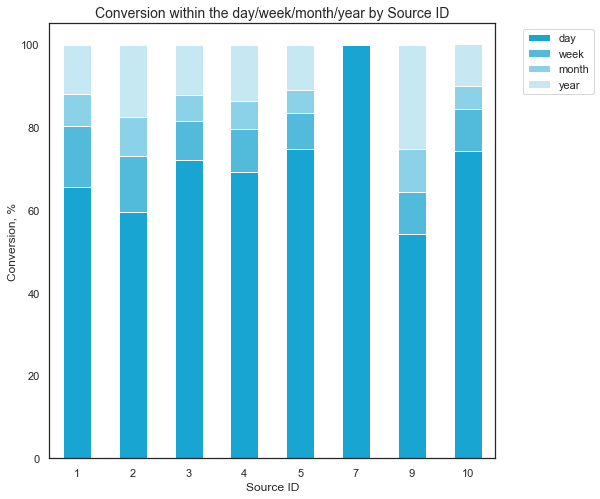

Number of customers per Source:


,source_id,count
0,1,3743
1,2,4323
2,3,9138
3,4,9823
4,5,6839
5,7,1
6,9,1415
7,10,1241


In [321]:
id_source = visits_log[['uid', 'source_id']].groupby('uid')['source_id'].first()

conversion = conversion.merge(id_source,
                              how='inner',
                              on='uid')

conversion_source = conversion.groupby(['source_id', 'difference_days']).agg({'difference_days':'count'})
conversion_source = conversion_source.rename(columns={'difference_days':'count'}).reset_index()
source_conv = conversion_source.groupby('source_id').agg({'count':'sum'}).reset_index()

for index, row in source_conv.iterrows():
    source_conv.loc[index,'day'] = (conversion_source[(conversion_source.source_id == row.source_id) & 
                                                     (conversion_source.difference_days == 0)]['count'].sum()
                                    /source_conv.loc[index,'count']*100).round(1)
    
    source_conv.loc[index,'week'] = (conversion_source[(conversion_source.source_id == row.source_id) & 
                                                      (conversion_source.difference_days > 0) & 
                                                      (conversion_source.difference_days <= 6)]['count'].sum()
                                     /source_conv.loc[index,'count']*100).round(1)
    
    source_conv.loc[index,'month'] = (conversion_source[(conversion_source.source_id == row.source_id) & 
                                                    (conversion_source.difference_days > 6) & 
                                                       (conversion_source.difference_days <= 31)]['count'].sum()
                                      /source_conv.loc[index,'count']*100).round(1)
        
    source_conv.loc[index,'year'] = (conversion_source[(conversion_source.source_id == row.source_id) & 
                                                      (conversion_source.difference_days > 31)]['count'].sum()
                                     /source_conv.loc[index,'count']*100).round(1)

source_conv[['day', 'week', 'month', 'year']].plot(kind='bar',
                                                   color=['#18A5D1', '#52BBDC', '#8BD2E8', '#C5E8F3'],
                                                   figsize = (8,8),
                                                   stacked=True)

plt.title('Conversion within the day/week/month/year by Source ID', fontdict={'size':14})
plt.xticks(np.arange(source_conv.shape[0]), labels=source_conv['source_id'].tolist(), rotation=0)
plt.xlabel('Source ID')
plt.ylabel('Conversion, %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()    

print('Number of customers per Source:')
display(source_conv[['source_id', 'count']])

As we see on the bar chart above, the source with ID **7** has the best conversion: 100% of customers converted within the first day. But this source has only one customer, so it's not that representative. <br>
Sources with ID **3**, **5** and **10** have relatively fast conversion, while **2** and **9** have the slowest.

#### How many orders do customers make during a given period of time?

Let's find average number of orders that customers place per day, week and month:

In [217]:
orders_log['year']  = orders_log['buy_ts'].dt.year
orders_log['month'] = orders_log['buy_ts'].dt.month
orders_log['week']  = orders_log['buy_ts'].dt.week
orders_log['date'] = orders_log['buy_ts'].dt.date

orders_per_day = orders_log.groupby('date').agg({'uid': 'count'}).mean()
orders_per_week = orders_log.groupby('week').agg({'uid': 'count'}).mean()
orders_per_month = orders_log.groupby('month').agg({'uid': 'count'}).mean()

print("Average number of orders per day:", int(orders_per_day))
print("Average number of orders per week:", int(orders_per_week))
print("Average number of orders per month:", int(orders_per_month))

Average number of orders per day: 138
Average number of orders per week: 969
Average number of orders per month: 4201


Let's visualize how number of orders per month changes during the year:

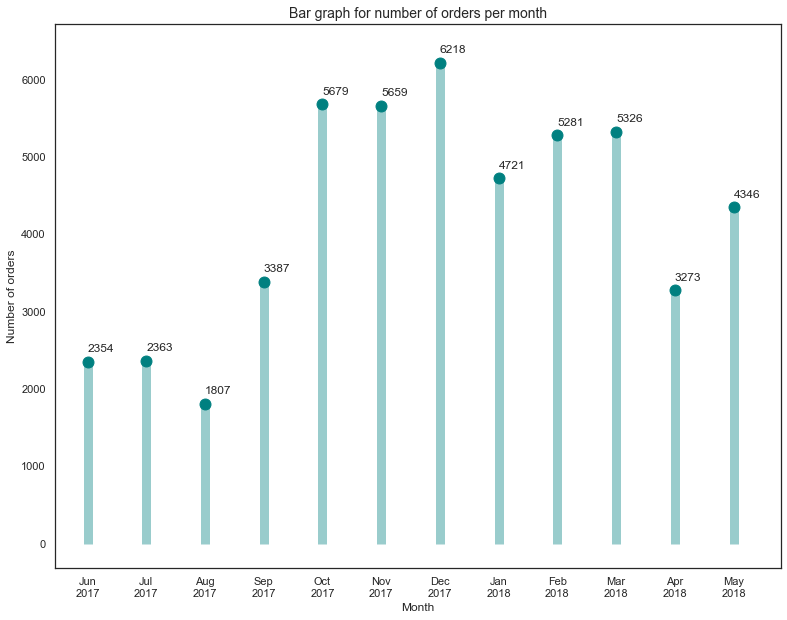

In [238]:
orders_per_month = orders_log.groupby(['year', 'month']).agg({'uid': 'count'}).reset_index()

monthly_lollipop_chart(df=orders_per_month,
                       y_values='uid',
                       decimal=0,
                       title='Bar graph for number of orders per month',
                       ylabel='Number of orders')    

Here we see the same tendency as with user activity above: more orders during the winter, especially December, less orders during the summer and also some drop in April.

Also, it turns out that there is one order from June 2018 in our database, probably by mistake. One order won't give us much information about that time period, we also don't have data on user activity and marketing expenses for June 2018, so let's just remove this row from the orders data frame:

In [219]:
orders_log.drop(orders_log.tail(1).index,inplace=True)

#### What is the average purchase size?

First of all, let's find average purchase size overall: 

In [328]:
round(orders_log.revenue.mean(), 1)

5.0

Let's see how average purchase size vary during the year:

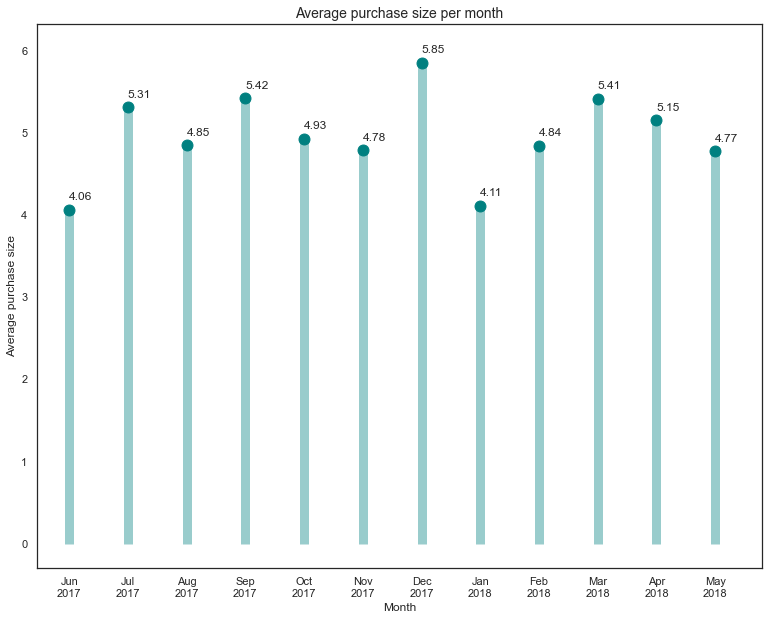

In [239]:
revenue_per_month = orders_log.groupby(['year', 'month']).agg({'revenue': 'mean'}).reset_index()

monthly_lollipop_chart(df=revenue_per_month,
                       y_values='revenue',
                       decimal=2,
                       title='Average purchase size per month',
                       ylabel='Average purchase size')      

Purchase size reaches its peak during December and lowest in January and June. What's interesting, even though user activity and number of orders are very low in April and during the summer, it doesn't correlate with average purchase size - in April and July it's happen to be higher than average.

#### How much money do they bring?

Here we are going to calculate **LTV** (lifetime value) — total amount of money a customer brings to the company on average by making purchases.

First of all, let's find LTV for monthly cohorts and see how it changes during cohort lifetime as we did above for retention rate. <br>
We want to split our users to the exactly the same cohorts, so later we can calculate ROMI (return of marketing investment based on that). We are also going to take into account users who didn't place any order, that just means that the LTV that they brought was 0, but they still should be considered as they cost the company some money to attract them too. <br>
So instead of splitting customers to cohorts by first order month, we are going to group them by first activity month. As we learned above, in most cases that is the same month, but still they can differ and grouping by first activity month would be more accurate. 

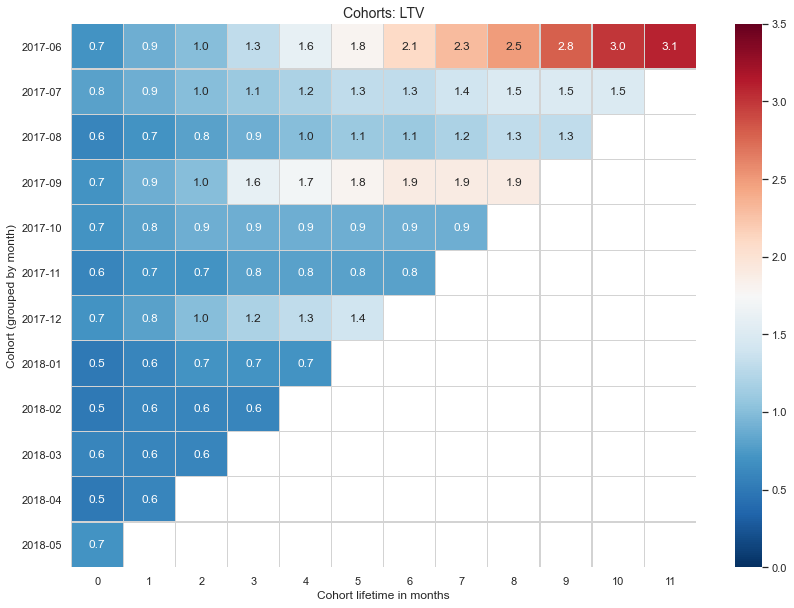

In [222]:
orders_log['order_month'] = orders_log['buy_ts'].astype('datetime64[M]')
id_first_activity_month = visits_log[['uid','first_activity_month']].groupby('uid')['first_activity_month'].first()

orders_log = orders_log.merge(id_first_activity_month,
                              how='inner',
                              on='uid')

ltv_grouped_by_cohorts = (orders_log
                          .groupby(['first_activity_month','order_month'])
                          .agg({'revenue':'sum'})).reset_index()

ltv_grouped_by_cohorts = ltv_grouped_by_cohorts.merge(initial_users_count,
                                                      how='left',
                                                      on='first_activity_month')

ltv_grouped_by_cohorts['revenue_per_user'] = (ltv_grouped_by_cohorts['revenue']
                                              /ltv_grouped_by_cohorts['cohort_users']).round(1)

ltv_grouped_by_cohorts['cohort_lifetime'] = ((ltv_grouped_by_cohorts['order_month'] -
                                              ltv_grouped_by_cohorts['first_activity_month'])
                                             /np.timedelta64(1,'M')).round().astype('int64')

ltv_grouped_by_cohorts['first_activity_month'] = (ltv_grouped_by_cohorts['first_activity_month']
                                                      .dt.strftime('%Y-%m'))

ltv_pivot = ltv_grouped_by_cohorts.pivot_table(index='first_activity_month',
                                               columns='cohort_lifetime',
                                               values='revenue_per_user').cumsum(axis=1)

sns.set(style='white')
fig,ax = plt.subplots(figsize = (14,10))
sns.heatmap(ltv_pivot, 
            annot=True,
            cmap='RdBu_r', 
            fmt='.1f', 
            linewidths=0.1, 
            linecolor='lightgrey',
            vmin = 0,
            vmax = 3.5,
           );
ax.set_title('Cohorts: LTV', fontdict ={'size':14})
ax.set_xlabel('Cohort lifetime in months', fontdict ={'size':12})
ax.set_ylabel('Cohort (grouped by month)', fontdict ={'size':12})
ax.set_yticklabels(retention_pivot.index, rotation=0)
plt.show()

From the heatmap above we can say that the *June 2017* cohort brought the highest revenue per user among all others, and not only because its lifetime is the longest, but also dynamics of the LTV growth for this cohort was the highest. The *September 2017* cohort also showed good results. <br>
Last 7-8 months have relatively low LTV, which almost doesn't increase within cohort lifetime, that applies especially for the last 5 months. Even though their lifetime is short yet, we already can say that we don't see the same growth dynamics here as older cohorts have. Exception to that can be *December 2017*, this cohort has a good LTV growth rate.

Let's calculate LTV for cohorts grouped by source:

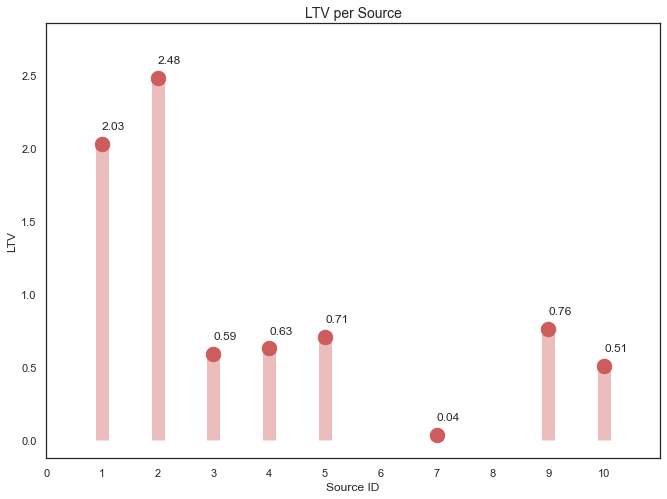

In [223]:
orders_log = orders_log.merge(id_source,
                              how='inner',
                              on='uid')

ltv_grouped_by_source = (orders_log
                          .groupby(['source_id'])
                          .agg({'revenue':'sum'})).reset_index()

number_users_per_source = (visits_log
                          .groupby(['source_id'])
                          .agg({'uid':'nunique'})).reset_index()

ltv_grouped_by_source = ltv_grouped_by_source.merge(number_users_per_source,
                                                    how='inner',
                                                    on='source_id')

ltv_grouped_by_source['ltv'] = ltv_grouped_by_source['revenue'] / ltv_grouped_by_source['uid']

def source_lollipop_chart(df, y_values, decimal, title, ylabel):
    fig,ax = plt.subplots(figsize = (11,8))
    
    ax.vlines(x=df.source_id, 
              ymin=0, 
              ymax=df[y_values], 
              color='indianred',
              alpha=0.4, 
              linewidth=13)
       
    ax.scatter(x=df.source_id, 
               y=df[y_values], 
               s=210, 
               color='indianred')
    
    shift = df[y_values].max()*0.04
    
    for index, row in df.iterrows():
        ax.text(x=row.source_id,
                y=row[y_values] + shift,
                s=round(row[y_values], decimal))   
    
    ax.set_title(title, fontdict ={'size':14})
    ax.set_ylabel(ylabel, fontdict ={'size':12})
    ax.set_xlabel('Source ID', fontdict ={'size':12})
    ax.set_ylim(ymax=df[y_values].max()*1.15)
    ax.set_xlim(xmax=11)
    ax.set_xticks(np.arange(11))
    ax.set_xticklabels(list(range(0, 11)))
    plt.show()

source_lollipop_chart(df=ltv_grouped_by_source,
                       y_values='ltv',
                       decimal=2,
                       title='LTV per Source',
                       ylabel='LTV')   

Traffic sources **1** and **2** are the most profitable bringing highest LTV among others. Sources **6** and **8** didn't bring any revenue at all, while source ID **7** brought revenue extremely close to 0, so those 3 sources are probably not worth investing into them.

### Marketing

#### How much money was spent?

Firstly, let's calculate how much money was spent on marketing overall:

In [224]:
costs.costs.sum()

329131.62

Now let's see how much was spent on each ad source that users came from:

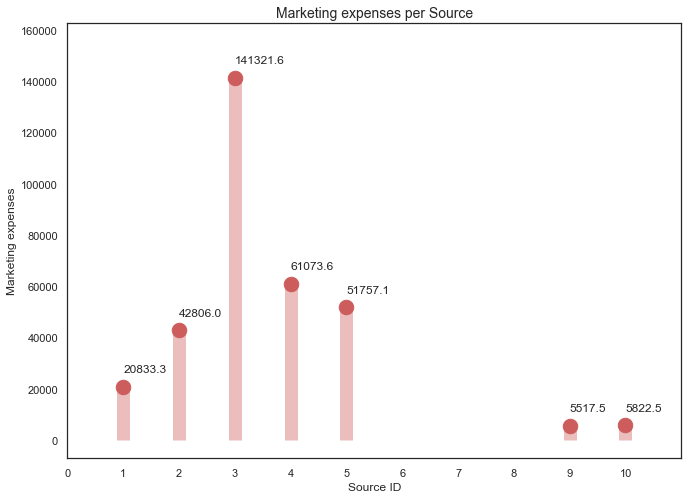

In [225]:
costs_per_source = costs.groupby('source_id').agg({'costs':'sum'}).reset_index() 

source_lollipop_chart(df=costs_per_source,
                       y_values='costs',
                       decimal=1,
                       title='Marketing expenses per Source',
                       ylabel='Marketing expenses') 

As we mentioned above, sources **6, 7** and **8** aren't bringing any profit, except for **7** which brings very low LTV close to 0, turns out that company doesn't spend any money on those 3 sources, so source **7** becomes actually profitable. The highest amount of money was spent on source **3** and this strategy might not be the best one as we saw on the LTV chart above, source 3 brings profit that is lower than average. Opposite situation with sources **1** and **2**: investments into those two sources are relatively low while they bring the highest revenue to the company. That's looking very promising and probably sources **1** and **2** are worth investing more into them. <br>
Also, sources **9** and **10** with very low marketing expenses on them bringing decent results. We will be able to tell if those sources are worth investments for sure on a later step, when we will be calculating ROMI (return of marketing investments) for each source. 

Let's plot a graph showing dynamics of marketing expenses per month during the year:

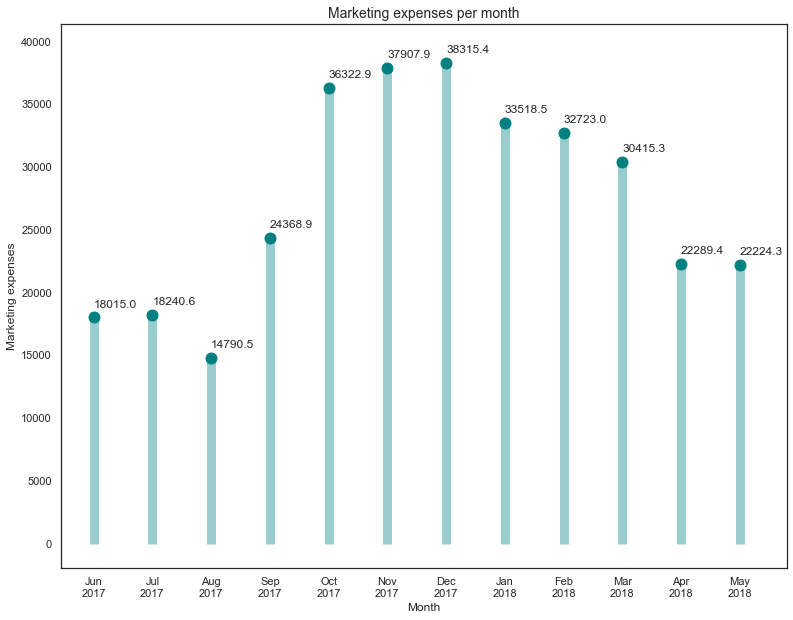

In [241]:
costs['year']  = costs['dt'].dt.year
costs['month'] = costs['dt'].dt.month

costs_per_month = costs.groupby(['year', 'month']).agg({'costs': 'sum'}).reset_index()

monthly_lollipop_chart(df=costs_per_month,
                       y_values='costs',
                       decimal=1,
                       title='Marketing expenses per month',
                       ylabel='Marketing expenses')

Here marketing costs graph repeats user activity and number of orders per month pattern. Maybe that pattern can be explained not only by seasons of the year, but rather by marketing expenses per month. During the summer marketing expenses were lowest and during the winter - highest.

#### How much did customer acquisition from each of the sources cost?

At this step we are going to calculate **CAC** (customer acquisition cost) — the cost of attracting a customer. <br>
First of all, let's find CAC for each traffic source: we're going to group total marketing costs by source and divide the costs by the number of users that came from that source:

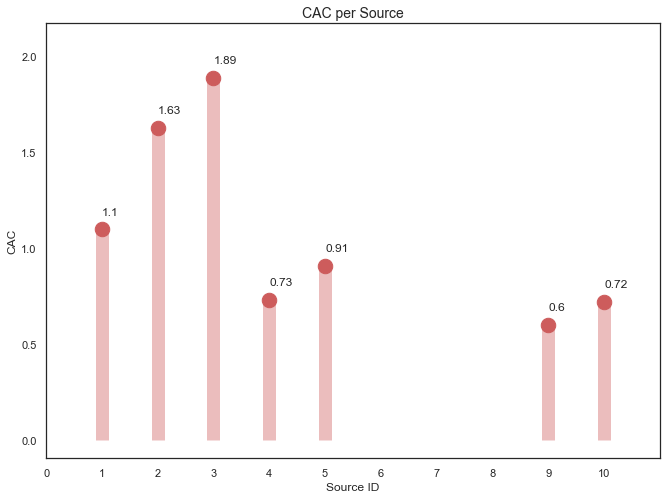

In [227]:
cac_per_source = costs_per_source.merge(number_users_per_source,
                                        how='left',
                                        on='source_id').fillna(0)

cac_per_source['cac'] = (cac_per_source['costs'] / cac_per_source['uid']).round(2)
cac_per_source

source_lollipop_chart(df=cac_per_source,
                       y_values='cac',
                       decimal=2,
                       title='CAC per Source',
                       ylabel='CAC')

Even though marketing expenses overall on source **1** and **2** were relatively low, we can tell from the chart above that their CAC are higher than average. But still the highest one is for source № **3**. For sources **6**, **7** and **8** CAC is 0, obviously.

Now let's calculate CAC per month:

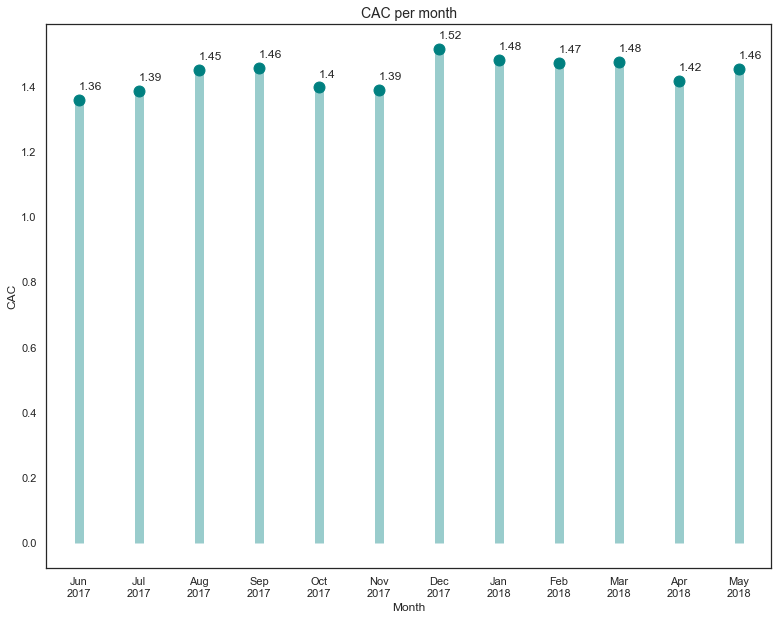

In [228]:
cac_per_month = costs_per_month.join(initial_users_count['cohort_users'].reset_index())
cac_per_month['cac'] = cac_per_month['costs'] / cac_per_month['cohort_users']

monthly_lollipop_chart(df=cac_per_month,
                       y_values='cac',
                       decimal=2,
                       title='CAC per month',
                       ylabel='CAC')

From this chart above we see that CAC doesn't differ much from month to month.

#### How worthwhile where the investments?

At this last step we are going to calculate **ROMI** — return of marketing investments. Firstly, let's calculate ROMI by source:

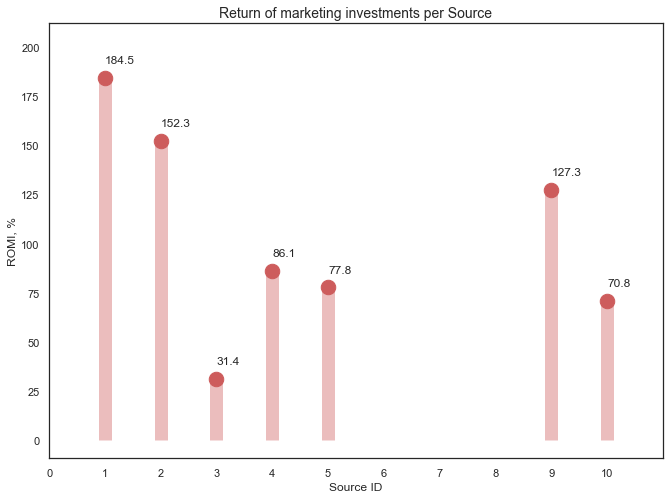

In [229]:
ltv_grouped_by_source = ltv_grouped_by_source.merge(cac_per_source[['source_id', 'cac']],
                                                    how='inner',
                                                    on='source_id')

ltv_grouped_by_source['romi'] = (ltv_grouped_by_source['ltv'] / ltv_grouped_by_source['cac'])*100

source_lollipop_chart(df=ltv_grouped_by_source,
                       y_values='romi',
                       decimal=1,
                       title='Return of marketing investments per Source',
                       ylabel='ROMI, %')

As we suspected, **1** and **2** sources are the most profitable. Also source **9** brings some profit. <br>
Sources **4, 5** and **10** aren't so promising, they haven't brought their investments back. Source **3** is very bad in terms of investment, only less than one-third of investments is coming back from it. 

Now let's find out ROMI for monthly cohorts:

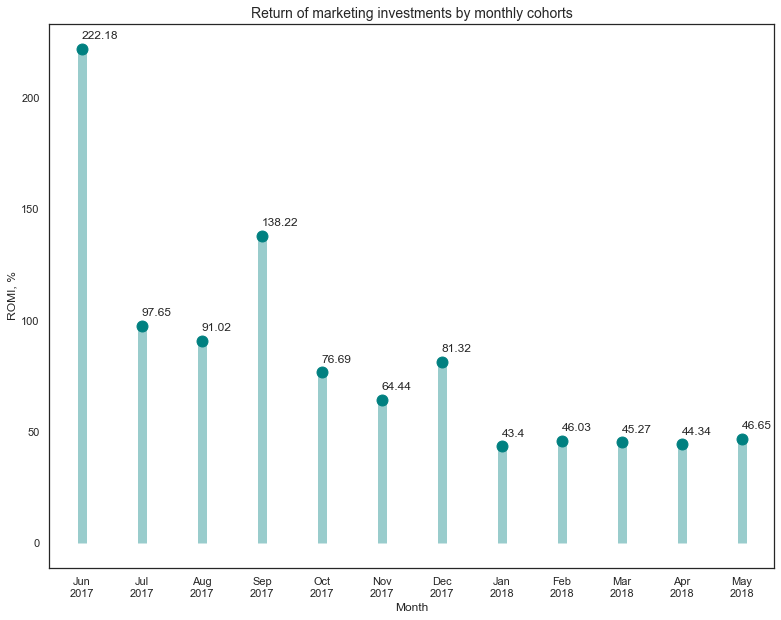

In [196]:
ltv_total = (ltv_grouped_by_cohorts
             .groupby(['first_activity_month','cohort_users'])
             .agg({'revenue':'sum'})).reset_index()

ltv_total['ltv_total'] = ltv_total['revenue'] / ltv_total['cohort_users']
ltv_total = ltv_total.join(cac_per_month['cac'])
ltv_total['romi'] = (ltv_total['ltv_total'] / ltv_total['cac'])*100

monthly_lollipop_chart(df=ltv_total,
                       y_values='romi',
                       decimal=2,
                       title='Return of marketing investments by monthly cohorts',
                       ylabel='ROMI, %')

**June 2017** cohort was the most profitable, it paid off more than twice and also **September 2017** showed good results. **July** and **August 2017** are about to pay off, while the latest cohorts are showing worse results, except for **December 2017**. Of course there is the time factor and latest cohorts would bring more money back over time, but as the LTV graph for monthly cohorts showed above, the dynamics for paying off is worse for latest cohorts than for first ones.

## Step 3. Overall conclusion

In this project we learned that average number of people using the service:
 - **907** per day
 - **5716** per week
 - **23228** per month

There is an increase in user activity during the winter, especially December, and decrease during the summer. There is also an activity drop for a few days in April.

Average number of sessions per user per one day is **1.09**. Majority of people use the service only once a day.

On average, desktop **devices** are making **73%** of all sessions and **touch** devices are making **27%**. Also, desktop sessions are longer, on average, than mobile device sessions. They last **11 minutes 43 seconds**, while on touch devices - **7 minutes 59 seconds**. <br>
In general, the average session duration is **10 minutes 43 seconds**. It decreases during the summer and increases during the winter, repeating the user activity pattern.

Most of the users are staying active only during the first month and only less than 9% of them would remain active during next months. In terms of retention, **June 2017** cohort showed the best results among others. For the latest months cohorts retention is dropping faster.

Majority of customers are making their first purchase within the same day of their registration. 
 - on average **69%** of all customers are placing order on the first day
 - another **11%** would make a purchase within the rest of the week
 - **7%** - within the rest of the month
 - **13%** within the rest of the year

Sources with ID **3**, **5** and **10** have relatively fast conversion, while **2** and **9** have the slowest.

Average number of orders:
 - **138** per day
 - **969** per week
 - **4201** per month
 
During the year the average number of orders per month is changing and repeating the user activity pattern: more orders during the winter, especially December, less orders during the summer and also some drop in April. 

Average purchase size is **5.0**. <br>
Purchase size reaches its peak during December and lowest in January and June. What's interesting, even though user activity and number of orders are very low in April and during the summer, it doesn't correlate with average purchase size - in April and July it's happen to be higher than average.

#### LTV
From the *LTV* heatmap for monthly cohorts we made a conclusion that the **June 2017** cohort brought the highest revenue per user among all others, and not only because its lifetime is the longest, but also dynamics of the *LTV* growth for this cohort was the highest. The **September 2017** cohort also showed good results.
Last 7-8 months have relatively low *LTV*, which almost doesn't increase within cohort lifetime, that applies especially for the last 5 months. Even though their lifetime is short yet, we already can say that we don't see the same growth dynamics here as older cohorts have. Exception to that can be **December 2017**, this cohort has a good *LTV* growth rate.

If we consider traffic sources in terms of *LTV*, sources **1** and **2** are the most profitable bringing highest *LTV* among others. Sources **6** and **8** didn't bring any revenue at all, while source ID **7** brought revenue extremely close to 0.

#### Marketing costs
Money spent on marketing during the year: **329131.62** <br>
Marketing expenses per month distribution repeat the pattern of user activity and number of orders per month. If we would split marketing costs by traffic source, source **3** got the highest investments. <br>
Sources **6, 7** and **8** didn't get any investments at all, but they also aren't bringing any customers, except for one customer that came from source **7**.

#### CAC
Even though marketing expenses overall on source **1** and **2** were relatively low, their *CAC* are higher than average. But the highest one is for source **3**. For sources **6, 7** and **8** *CAC* is 0, obviously. <br>

Marketing expenses vary from month to month, but so does the number of active users, as we learned, it changes proportionally. Thus, *CAC* doesn't differ much from month to month. 

#### ROMI
Sources **1** and **2** are the most profitable. Also source **9** brings some profit. Sources **4, 5** and **10** aren't so promising, they haven't brought their investments back. Source **3** is very bad in terms of investment, only less than one-third of investments is coming back from it, company should stop investing there so much money and invest into **1** and **2** instead.

When spliting users by monthly cohorts, we can tell that **June** and **September 2017** cohorts were the most profitable. Also **December 2017** showed good results. **July** and **August 2017** are almost paid off. <br>
Latest cohorts are doing much worse. Last 5 months cohorts haven't brought even half of the investments back yet. Taking into account that there's also a decrease in customer retention rate for those cohorts, it might mean that there is some issue that is taking place in the last 5 months and affecting user experience with the service.